In [1]:
import pandas as pd
from connections import *
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import IPython
import IPython.display
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import pymysql.cursors
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime, timedelta

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from IPython.display import clear_output

import gc
from tableone import TableOne

import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


2025-09-03 10:41:47.694290: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-03 10:41:47.702912: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-03 10:41:47.827064: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-03 10:41:47.884352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756896107.929924     112 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756896107.94

In [2]:
df_init = pd.read_pickle("data/extraction/nav_06_2025_v2.pkl")

In [3]:
df_init.drop(["AdmTimeHourlyBegin", "AdmTimeHourlyFinal", 
              "AdmTime", "DisTime", "date_0_ajustado", "fecha_2dias_vmi", 
             ], axis=1, inplace=True)

In [4]:
df_init['PatType'] = np.where(df_init['PatType']=="traumatic", "surgical", df_init['PatType'])

# PREPROCESSING

## RELLENAR CON VALORE FIJOS

In [5]:
df = df_init.copy()

In [6]:
df["traqueo"] = df["traqueo"].fillna(0)
df["MPOC"] = df["MPOC"].fillna(0)
df["reintubacion"] = df["reintubacion"].fillna(0)
df["antibioticos"] = df["antibioticos"].fillna(0)
df["n_aspiraciones_sum"] = df["n_aspiraciones_sum"].fillna(0)
df["diuresis_sum"] = df["diuresis_sum"].fillna(0)
df["noradrenalina_sum"] = df["noradrenalina_sum"].fillna(0)
df["aspecto_secreciones_purulentas"] = df["aspecto_secreciones_purulentas"].fillna(0)
df[["fio2_median", "fio2_min", "fio2_max"]] = df[["fio2_median", "fio2_min", "fio2_max"]].fillna(21)

In [7]:
np.random.seed(42)

# Definir las columnas relevantes
columnas = ['spo2_median']

# Iterar sobre las columnas relevantes
for columna in columnas:
    # Generar valores aleatorios para los NaN en la columna actual
    valores_aleatorios = np.random.choice([96, 97, 98, 99, 100], size=len(df[df[columna].isnull()]))
    
    # Rellenar NaN en la columna actual con valores aleatorios
    null_indices = df[columna].isnull()
    df.loc[null_indices, columna] = valores_aleatorios

df['spo2_max'] = np.where(df['spo2_max'].isnull(), df['spo2_median'], df['spo2_max'])
df['spo2_min'] = np.where(df['spo2_min'].isnull(), df['spo2_median'], df['spo2_min'])

## RELLENAR SOFA

In [8]:
df["sofa_median"] = np.where(df["sofa_median"].isnull(), df["sofa_imp"], df["sofa_median"])
df.drop("sofa_imp", axis=1, inplace=True)

## FFILL

In [9]:
cols_monitorizadas = [
    'peep_median', 'peep_min', 'peep_max',
    'vt_median', 'vt_min', 'vt_max',
    'pr_peak_median', 'pr_peak_min', 'pr_peak_max',
    'pr_plateau_median', 'pr_plateau_min', 'pr_plateau_max',
    'spo2_median', 'spo2_min', 'spo2_max', 
    'fr_median', 'fr_min', 'fr_max',
    'fc_median', 'fc_min', 'fc_max',
    'pam_median', 'pam_min', 'pam_max', 
    'MP',
]

cols_ffill = [
    'temperatura_median', 'temperatura_min', 'temperatura_max',
    'pafi_median', 'pafi_min', 'pafi_max',
    'leucocitos_median', 'leucocitos_min', 'leucocitos_max', 
    'linfocitos_median', 'linfocitos_min', 'linfocitos_max', 
    'pcr_median', 'pcr_min', 'pcr_max',
    'pct_median', 'pct_min', 'pct_max', 
    'creatinina_median', 'creatinina_min', 'creatinina_max', 
    'glucosa_median', 'glucosa_min', 'glucosa_max',
    'ph_median', 'ph_min', 'ph_max',
    'lactato_median', 'lactato_min', 'lactato_max',
    'consistencia_secreciones', 'aspecto_secreciones_purulentas',
    'gcs_min'
]

# Forward fill agrupado por PatientID solo una ventana
df = df.sort_values(['PatientID', 'hr'], ascending=True)
df[cols_monitorizadas] = df.groupby('PatientID')[cols_monitorizadas].ffill()
df[cols_ffill] = df.groupby('PatientID')[cols_ffill].ffill()

In [10]:
# Calcular porcentaje de valores faltantes para diferentes horas
for hr_value in [-24, -48, -72]:
    subset = df[df.hr == hr_value]
    
    if len(subset) == 0:
        print(f"No hay datos para hr == {hr_value}")
        continue
    
    missing_percentages = round(subset.isnull().mean() * 100, 2)
    
    print(f"\nPercentage of missing values for each variable at hr = {hr_value}:")
    print(missing_percentages[missing_percentages > 30])



Percentage of missing values for each variable at hr = -24:
pct_median    32.84
pct_min       32.84
pct_max       32.84
dtype: float64

Percentage of missing values for each variable at hr = -48:
pct_median    32.08
pct_min       32.08
pct_max       32.08
dtype: float64

Percentage of missing values for each variable at hr = -72:
pct_median    31.14
pct_min       31.14
pct_max       31.14
dtype: float64


# STATISTICAL ANALYSIS

In [11]:
# Filtrar el dataframe para los diferentes valores de hr
df_hr_minus_24 = df[df['hr'] == -24].copy()

In [12]:
# Definir columnas y variables categóricas
columns = list(df.drop(["PatientID", "hr"], axis=1).columns)
categorical = ['Sex', 'AdmType', 'PatType', 'traqueo', 
               'consistencia_secreciones', 'aspecto_secreciones_purulentas', 'antibioticos', 'exitus',
               'MPOC',
               'reintubacion'
              ]

table_hr_minus_24 = TableOne(df_hr_minus_24, columns=columns, categorical=categorical, nonnormal=set(columns) - set(categorical),
                             groupby='NAV', pval=True, htest_name=True, 
                             dip_test=True, normal_test=True, tukey_test=True, missing=True)

# Extraer los DataFrames subyacentes de las tablas
table_hr_minus_24_df = table_hr_minus_24.tableone

/opt/conda/lib/python3.11/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/opt/conda/lib/python3.11/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/opt/conda/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  

In [13]:
table_hr_minus_24_df

Grouped by NAV  \
                                                         Missing   
n                                                                  
Sex, n (%)                            F                        0   
                                      M                            
AdmType, n (%)                        scheduled                0   
                                      urgent                       
PatType, n (%)                        medical                  0   
                                      surgical                     
Age, median [Q1,Q3]                                            0   
ICU_days, median [Q1,Q3]                                       0   
dias_VMI, median [Q1,Q3]                                       0   
exitus, n (%)                         0.0                      0   
                                      1.0                          
peso, median [Q1,Q3]                                           0   
traqueo, n (%)                        0.0                      0   
                                      1.0                          
MPOC, n (%)                           0.0                      0   
                                      1.0                          
fio2_median, median [Q1,Q3]                                    0   
fio2_min, median [Q1,Q3]                                       0   
fio2_max, median [Q1,Q3]                                       0   
temperatura_median, median [Q1,Q3]                             0   
temperatura_min, median [Q1,Q3]                                0   
temperatura_max, median [Q1,Q3]                                0   
peep_median, median [Q1,Q3]                                    4   
peep_min, median [Q1,Q3]                                       4   
peep_max, median [Q1,Q3]                                       4   
fr_median, median [Q1,Q3]                                     46   
fr_min, median [Q1,Q3]                                        46   
fr_max, median [Q1,Q3]                                        46   
spo2_median, median [Q1,Q3]                                    0   
spo2_min, median [Q1,Q3]                                       0   
spo2_max, median [Q1,Q3]                                       0   
vt_median, median [Q1,Q3]                                     30   
vt_min, median [Q1,Q3]                                        30   
vt_max, median [Q1,Q3]                                        30   
pr_peak_median, median [Q1,Q3]                                22   
pr_peak_min, median [Q1,Q3]                                   22   
pr_peak_max, median [Q1,Q3]                                   22   
pr_plateau_median, median [Q1,Q3]                            202   
pr_plateau_min, median [Q1,Q3]                               202   
pr_plateau_max, median [Q1,Q3]                               202   
fc_median, median [Q1,Q3]                                      0   
fc_min, median [Q1,Q3]                                         0   
fc_max, median [Q1,Q3]                                         0   
pam_median, median [Q1,Q3]                                     0   
pam_min, median [Q1,Q3]                                        0   
pam_max, median [Q1,Q3]                                        0   
pafi_median, median [Q1,Q3]                                   44   
pafi_min, median [Q1,Q3]                                      44   
pafi_max, median [Q1,Q3]                                      44   
MP, median [Q1,Q3]                                           267   
leucocitos_median, median [Q1,Q3]                             32   
leucocitos_min, median [Q1,Q3]                                32   
leucocitos_max, median [Q1,Q3]                                32   
linfocitos_median, median [Q1,Q3]                             22   
linfocitos_min, median [Q1,Q3]                                22   
linfocitos_max, median [Q1,Q3]                                22   
pcr_median, median [Q1,Q3]            

# ENCODING

In [14]:
# Identificar columnas categóricas multiclase (con más de 2 clases)
categorical_columns = [col for col in df.select_dtypes(include=['object', 'category']).columns if df[col].nunique() >= 2]

# Imprimir los resultados
print("Categorical columns:", categorical_columns)

Categorical columns: ['Sex', 'AdmType', 'PatType', 'consistencia_secreciones']


In [15]:
# Codificación para columnas multiclase (más de 2 clases)
df_encoded = pd.get_dummies(df, columns=categorical_columns)

In [17]:
df_encoded.drop(["Sex_F"], axis=1, inplace=True)

In [ ]:
df_encoded.to_pickle("data/extraction/nav_processed_v2.pkl")

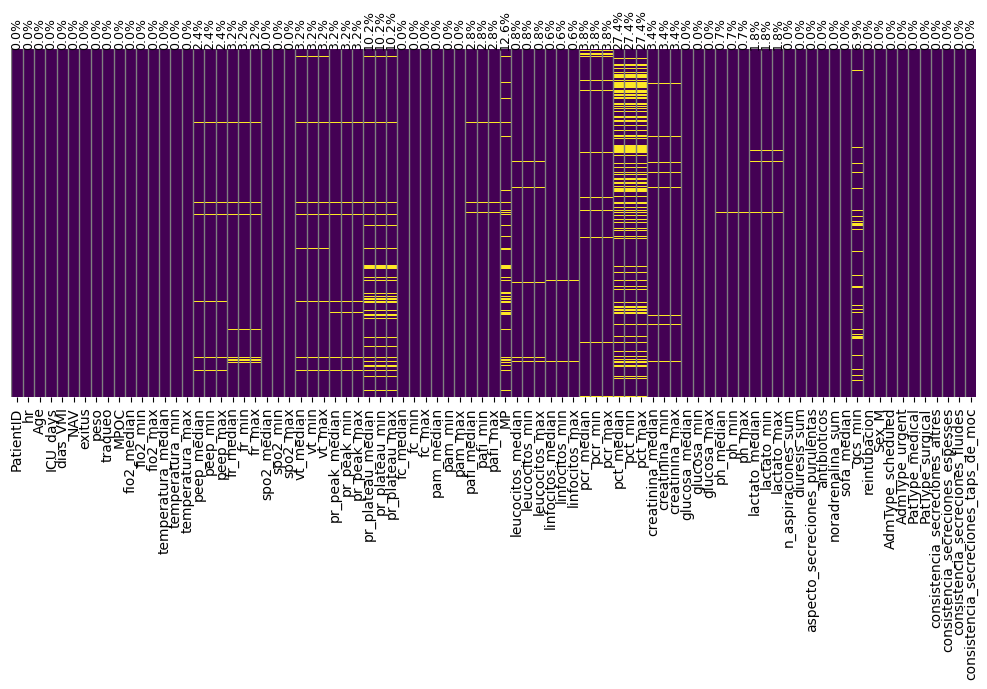

In [18]:
# Calcular el porcentaje de nulos por columna
null_percentages = df_encoded.isnull().mean() * 100

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(df_encoded.isnull(), xticklabels=True, yticklabels=False, cbar=False, cmap='viridis', ax=ax)

# Añadir líneas verticales
num_columns = df_encoded.shape[1]
for index in range(num_columns):
    ax.axvline(index, color='gray', linewidth=1)

# Añadir texto con el porcentaje de nulos encima de cada columna (usando coordenadas de ejes)
for idx, col in enumerate(df_encoded.columns):
    percent = null_percentages[col]
    ax.text(idx + 0.5, -5.5, f"{percent:.1f}%", ha='center', va='bottom', fontsize=9, rotation=90, color='black', transform=ax.transData)

ax.set_xticklabels(df_encoded.columns, rotation=90)
plt.tight_layout()
plt.show()
